## Looking for the best ratio between labeled and unlabeled images in Self-training with Noisy Student

### Author: Yu Huang(yh3019)

**This code is to visualize the evaluation metrics of models, which are trained with different ratios of unlabeled data to labeled data.**

In [4]:
from __future__ import print_function

import os
import pickle

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from keras.utils import np_utils
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from efficientnet.tfkeras import EfficientNetB0, EfficientNetB7
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings 
warnings.simplefilter(action='ignore')

In [3]:
!pip install opencv-python
!pip install efficientnet
# !pip install imgaug

  Using cached opencv_python-4.2.0.34-cp37-cp37m-manylinux1_x86_64.whl (28.2 MB)
  Using cached efficientnet-1.1.0-py3-none-any.whl (18 kB)


In [5]:
keras.__version__, tf.__version__

('2.2.4-tf', '1.13.1')

In [21]:
def pesodu_label_generator(model_teacher, x_unlabel1):
    teacher_model = load_model("./models/"+model_teacher+".hdf5", custom_objects={"f1_m": f1_m})
    
    # preprocess unlabeled x 
    x_unlabel1 = x_unlabel1.astype('float32')
    x_unlabel1 = x_unlabel1/255.
    
    # Predict psuedo labels
    y_proba1   = teacher_model.predict(x_unlabel1)
    y_predict1 = np.argmax(y_proba1, axis=1)
    y_unlabel1 = keras.utils.to_categorical(y_predict1, num_classes)
    
    return teacher_model, y_unlabel1, y_predict1

# Here we use F1-score and categorical_accuracy as evaluation metrics
import keras.backend as K

def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

## 1. MNIST dataset

### Import test dataset

In [22]:
x_test = np.load('./predictions/x_test_Mnist.npy')
y_test = np.load('./predictions/y_test_Mnist.npy') # load
# num_label = 5000
num_classes = 10

#### Predict with models trained by different R values

In [5]:
model_name = ['studentmodel2_1000i_Mnist_20e_drop05_R1',
              'studentmodel2_1000i_Mnist_20e_drop05_R4' ]

Ratio = ['R1',  
         'R4'] 

for mod, R in zip(model_name, Ratio):
    print('Prediction for ', R, ' started.')
    model, y_pred, y_proba = pesodu_label_generator(mod, x_test)
    y_pred1 = y_pred.argmax(axis=-1)
    np.save('./predictions/y_pred_1000i_Mnist_'+R+'_20e.npy', y_pred)
    np.save('./predictions/y_pred1_1000i_Mnist_'+R+'_20e.npy', y_pred1)
    print('Prediction for ', R, ' finished.')

Prediction for  R1  started.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Prediction for  R1  finished.
Prediction for  R4  started.
Prediction for  R4  finished.


In [65]:
del y_pred1, y_pred

In [66]:
# mod = 'studentmodel2_1000i_SVHN_100e_drop05_R6-30-0.69_0.61'
# R   = 'R6'
# model, y_pred, y_proba = pesodu_label_generator(mod, x_test)
# y_pred1 = y_pred.argmax(axis=-1)
# np.save('./predictions/y_pred_1000i_'+R+'_100e.npy', y_pred)
# np.save('./predictions/y_pred1_1000i_'+R+'_100e.npy', y_pred1)

In [23]:
y_R1_stu2_1 = np.load('./predictions/y_pred1_1000i_Mnist_R1_20e.npy')
y_R2_stu2_1 = np.load('./predictions/y_student2_R2_20e.npy')
y_R3_stu2_1 = np.load('./predictions/y_student2_R3_20e.npy')
y_R4_stu2_1 = np.load('./predictions/y_pred1_1000i_Mnist_R4_20e.npy')
#y_R45_stu2_1 = np.load('./predictions/y_student2_R4.5_20e_augv3.npy')
y_R5_stu2_1 = np.load('./predictions/y_student2_R5.5_20e_augv3.npy')
y_R6_stu2_1 = np.load('./predictions/y_student2_R6_20e_augv3.npy')

#### Calculate F1-score & Balanced Accuracy

In [24]:
f1  = []
ba1 = []
acc = []
model = [1, 2, 3, 4,5,6]
model_name = ['R=1', 'R=2', 'R=3', 'R=4','R=5','R=6']

for i in [y_R1_stu2_1, y_R2_stu2_1, y_R3_stu2_1, y_R4_stu2_1,y_R5_stu2_1,y_R6_stu2_1]:

    f1.append(f1_score(y_test, i, labels=None, average='macro'))
    ba1.append(balanced_accuracy_score(y_test, i))
    acc.append(accuracy_score(y_test,i))

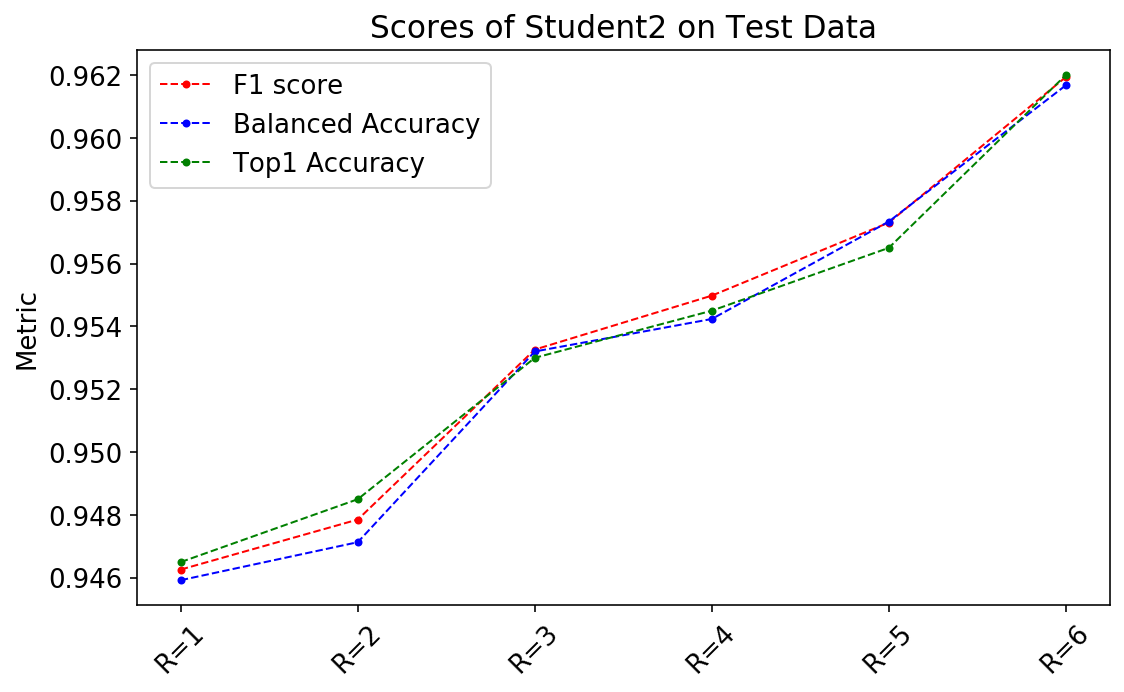

In [25]:
mpl.rc('font', size = 13)
fig, ax = plt.subplots(figsize=(8,5),ncols=1)

ax.plot(model, f1, c = 'r',marker = 'o', linestyle='dashed', linewidth=1, markersize=3,label='F1 score')
ax.plot(model, ba1, c = 'b',marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Balanced Accuracy')
ax.plot(model, acc, c = 'g',marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Top1 Accuracy')

ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Metric')
ax.set_title('Scores of Student2 on Test Data')
ax.set_xticks(model)
ax.set_xticklabels(model_name, rotation=45)

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
plt.savefig('./Figures/Mnist_F1_studentmodel2_R1toR6_1000i_drop05.png')

In [45]:
f1, ba1,acc

([0.9462617422667723,
  0.9478530557957505,
  0.9532624459950914,
  0.9549790062624048,
  0.9573037820334704,
  0.9619357971450894],
 [0.9459232454977814,
  0.9471325648211115,
  0.9532012873232398,
  0.954235791155741,
  0.957337359727628,
  0.9616734682501763],
 [0.9465, 0.9485, 0.953, 0.9545, 0.9565, 0.962])

## 2. SVHN dataset

In [26]:
x_test = np.load('./predictions/x_test.npy')
y_test = np.load('./predictions/y_test.npy') # load
# num_label = 5000
num_classes = 10

In [27]:
y_R1_stu2 = np.load('./predictions/y_pred1_1000i_R1_100e.npy')
y_R2_stu2 = np.load('./predictions/y_pred1_1000i_R2_100e.npy')
y_R3_stu2 = np.load('./predictions/y_pred1_1000i_R3_100e.npy') 
y_R4_stu2 = np.load('./predictions/y_pred1_1000i_R4_100e.npy')
y_R5_stu2 = np.load('./predictions/y_pred1_1000i_R5_100e.npy')
y_R6_stu2 = np.load('./predictions/y_pred1_1000i_R6_100e.npy')

In [28]:
f2  = []
ba2 = []
acc2 = []
model = [1, 2, 3, 4,5,6]
model_name = ['R=1', 'R=2', 'R=3', 'R=4','R=5','R=6']

for i in [y_R1_stu2, y_R2_stu2, y_R3_stu2, y_R4_stu2,y_R5_stu2,y_R6_stu2]:

    f2.append(f1_score(y_test.argmax(axis=-1), i, labels=None, average='macro'))
    ba2.append(balanced_accuracy_score(y_test.argmax(axis=-1), i))
    acc2.append(accuracy_score(y_test.argmax(axis=-1),i))

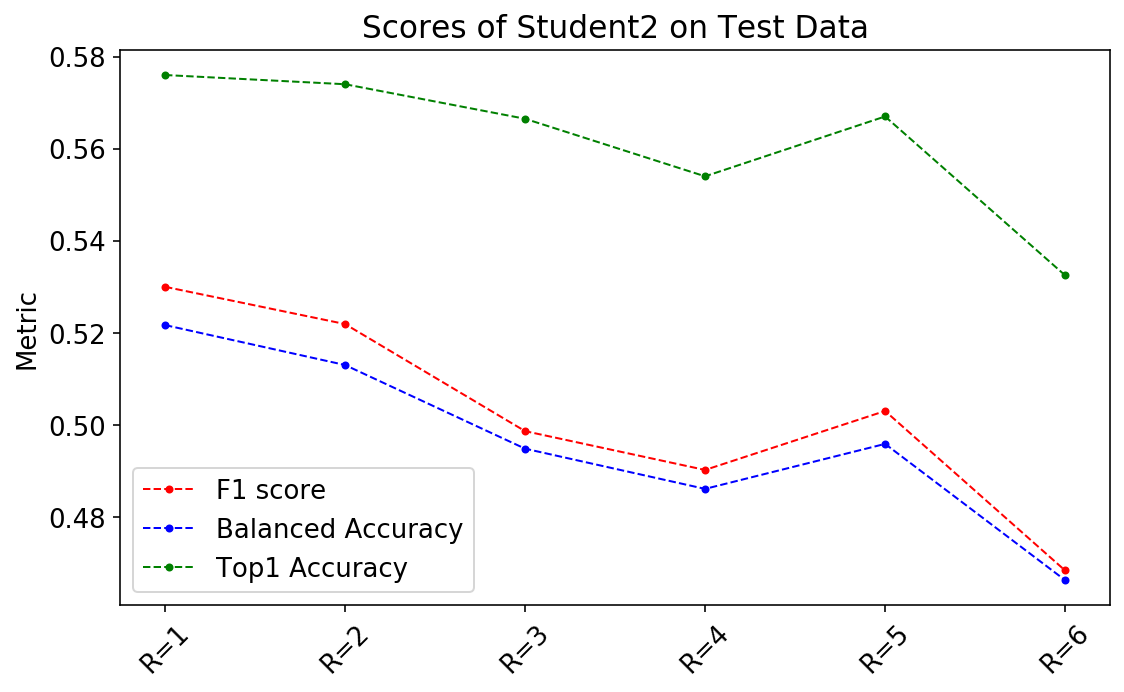

In [29]:
mpl.rc('font', size = 13)
fig, ax = plt.subplots(figsize=(8,5),ncols=1)

ax.plot(model, f2, c = 'r',marker = 'o', linestyle='dashed', linewidth=1, markersize=3,label='F1 score')
ax.plot(model, ba2, c = 'b',marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Balanced Accuracy')
ax.plot(model, acc2, c = 'g',marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Top1 Accuracy')

ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Metric')
ax.set_title('Scores of Student2 on Test Data')
ax.set_xticks(model)
ax.set_xticklabels(model_name, rotation=45)

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
plt.savefig('./Figures/SVHN_F1_studentmodel2_R1toR6_1000i_drop05.png')

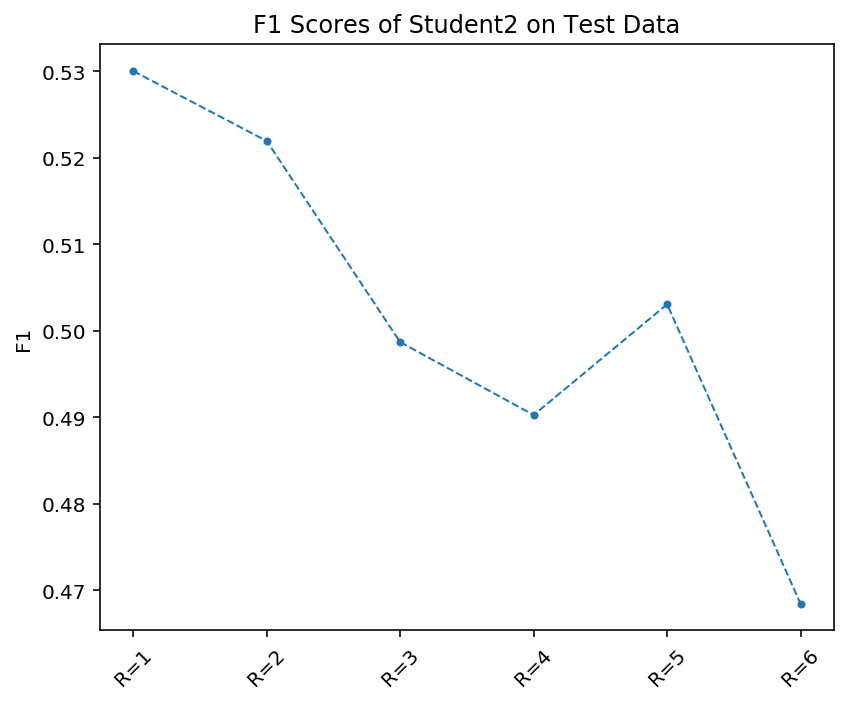

In [16]:
fig, ax = plt.subplots(figsize=(6,5),ncols=1)

ax.plot(model, f1, marker = 'o', linestyle='dashed', linewidth=1, markersize=3)
ax.set_xlabel('')
ax.set_ylabel('F1')
ax.set_title('F1 Scores of Student2 on Test Data')
ax.set_xticks(model)
ax.set_xticklabels(model_name, rotation=45)

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
plt.savefig('./Figures/F1_studentmodel2_R1toR6_1000i_drop05.png')